In [1]:
import imp
import os
import logging

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly
import statsmodels

from BuildingControlsSimulator.Simulator.Simulator import Simulator
from BuildingControlsSimulator.Simulator.Config import Config
from BuildingControlsSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlsSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlsSimulator.ControllerModels.Deadband import Deadband

from BuildingControlsSimulator.DataClients.LocalSource import LocalSource
from BuildingControlsSimulator.DataClients.LocalDestination import LocalDestination
from BuildingControlsSimulator.DataClients.DataSpec import DonateYourDataSpec
from BuildingControlsSimulator.DataClients.DataClient import DataClient
from BuildingControlsSimulator.DataClients.GCSDYDSource import GCSDYDSource
from BuildingControlsSimulator.OutputAnalysis.OutputAnalysis import OutputAnalysis
from BuildingControlsSimulator.StateEstimatorModels.LowPassFilter import LowPassFilter
from BuildingControlsSimulator.DataClients.DataStates import STATES

plotly.offline.init_notebook_mode(connected=True)
%load_ext autoreload
%autoreload 2


In [2]:
!energyplus --version

EnergyPlus, Version 9.4.0-998c4b761e


In [3]:
# choose number of simulations to match
n_simulations = 2
sim_ids = ["tmy_2756663bc57afe940c552ab1080f2ec09ef54e24"]*n_simulations

In [4]:
# edit input data file
# because of issue with zip comression, just unzip all DYD files you want to work with and put them in data/input/local
_df = pd.read_csv("../data/input/local/2756663bc57afe940c552ab1080f2ec09ef54e24.csv")

In [5]:
# inject TMY weather data here
_df["T_out"] = 60.0
_df["RH_out"] = 25.0

In [6]:
# change setpoint schedule
_df["DateTime"] = pd.to_datetime(_df["DateTime"])
_df.loc[(_df["DateTime"].dt.hour >= 8) & (_df["DateTime"].dt.hour <= 16), ["T_stp_heat"]] = 60.0
_df.loc[(_df["DateTime"].dt.hour < 8) & (_df["DateTime"].dt.hour > 16), ["T_stp_heat"]] = 60.0
_df.loc[(_df["DateTime"].dt.hour >= 8) & (_df["DateTime"].dt.hour <= 16), ["T_stp_cool"]] = 78.0
_df.loc[(_df["DateTime"].dt.hour < 8) & (_df["DateTime"].dt.hour > 16), ["T_stp_cool"]] = 74.0

In [7]:
_df.to_csv("../data/input/local/tmy_2756663bc57afe940c552ab1080f2ec09ef54e24.csv", index=False,)

In [8]:
# you can read back the data and validate it before running the simulations
r_df = pd.read_csv("../data/input/local/tmy_2756663bc57afe940c552ab1080f2ec09ef54e24.csv")

In [9]:
start_utc_list = [str(date) for date in _df["DateTime"].dt.date.unique()]

In [10]:
len(start_utc_list)

282

In [11]:
sim_config = Config.make_sim_config(
    identifier=sim_ids,
    latitude=[33.481136]*n_simulations,
    longitude=[-112.078232]*n_simulations,
    start_utc=["2018-07-05", "2018-07-06"],
    end_utc=["2018-07-06", "2018-07-07"],
    min_sim_period=["1D"]*n_simulations,
    sim_step_size_seconds=[300]*n_simulations,
    output_step_size_seconds=[300]*n_simulations,
)

In [12]:
dyd = DataClient(
    source=LocalSource(
        local_cache=os.environ.get("LOCAL_CACHE_DIR"),
        data_spec=DonateYourDataSpec(),
    ),
    destination=LocalDestination(
        local_cache=os.environ.get("LOCAL_CACHE_DIR"),
        data_spec=DonateYourDataSpec(),
    ),
    nrel_dev_api_key=os.environ.get("NREL_DEV_API_KEY"),
    nrel_dev_email=os.environ.get("NREL_DEV_EMAIL"),
    archive_tmy3_meta=os.environ.get("ARCHIVE_TMY3_META"),
    archive_tmy3_data_dir=os.environ.get("ARCHIVE_TMY3_DATA_DIR"),
    ep_tmy3_cache_dir=os.environ.get("EP_TMY3_CACHE_DIR"),
    simulation_epw_dir=os.environ.get("SIMULATION_EPW_DIR"),
)

In [13]:
sim_config

,identifier,latitude,longitude,start_utc,end_utc,min_sim_period,min_chunk_period,sim_step_size_seconds,output_step_size_seconds
0,tmy_2756663bc57afe940c552ab1080f2ec09ef54e24,33.481136,-112.078232,2018-07-05 00:00:00+00:00,2018-07-06 00:00:00+00:00,1 days,30 days,300,300
1,tmy_2756663bc57afe940c552ab1080f2ec09ef54e24,33.481136,-112.078232,2018-07-06 00:00:00+00:00,2018-07-07 00:00:00+00:00,1 days,30 days,300,300


In [14]:
%%time
master = Simulator(
    data_client=dyd,
    sim_config=sim_config,
    building_models=[
        EnergyPlusBuildingModel(
            idf=IDFPreprocessor(idf_file="../test/idf/v9-4-0/slab_1story_2000sqft_gasfurnace_AC.idf",
            building_config={
                "infiltration_ventilation": {
                    "ach50": 8,
                    "wsf": 0.43,
                },
                "insulation_r_si": {
                    "Interior Ceiling": 5.3,
                    "Exterior Wall": 2.0,
                    "Exterior Floor": 1.8,
                },
                "windows": {
                    "u_factor": 1.2,
                    "solar_heat_gain": 0.20,
                    "visible_transmittance": 0.60,
                },
                "hvac": {
                    "heating_stages": 1,
                    "heating_equipment": "gas_furnace",
                    "heating_sizing_factor": 2.0,
                    "cooling_stages": 1,
                    "cooling_equipment": "dx_ac",
                    "cooling_sizing_factor": 2.0,
                },
                "thermal_mass": 1e7,
            }),
        )
    ],
    state_estimator_models=[
        LowPassFilter(alpha_temperature=0.3, alpha_humidity=0.3)
    ],
    controller_models=[Deadband(deadband=1.0),],
)


CPU times: user 2.91 s, sys: 78.2 ms, total: 2.99 s
Wall time: 2.99 s


In [15]:
%%time
# simulate
master.simulate(local=True, preprocess_check=False)

/home/bcs/lib/bcs_venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/bcs/lib/bcs_venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



CPU times: user 23.2 s, sys: 1.15 s, total: 24.3 s
Wall time: 1min 23s


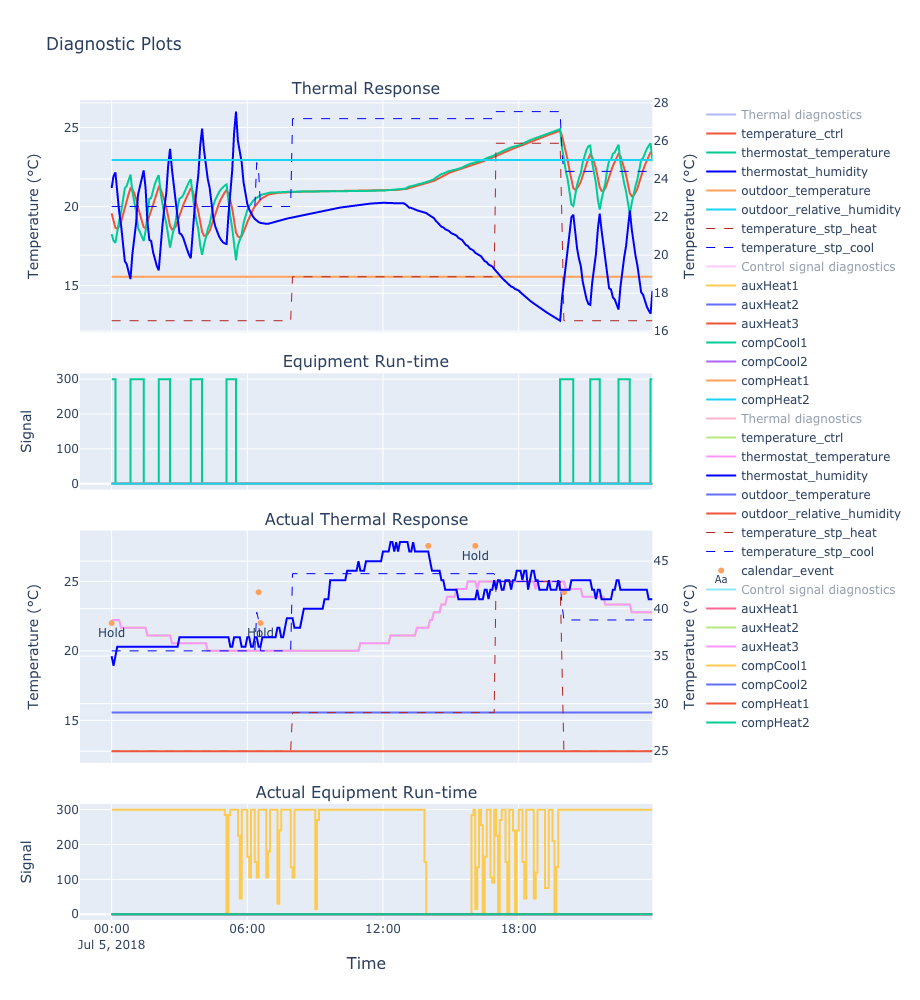

In [16]:
sim_analysis = OutputAnalysis(output_df=master.simulations[0].output, input_df=master.simulations[0].full_input, data_spec=dyd.internal_spec)
sim_analysis.diagnostic_plot(show=True, actuals=True)

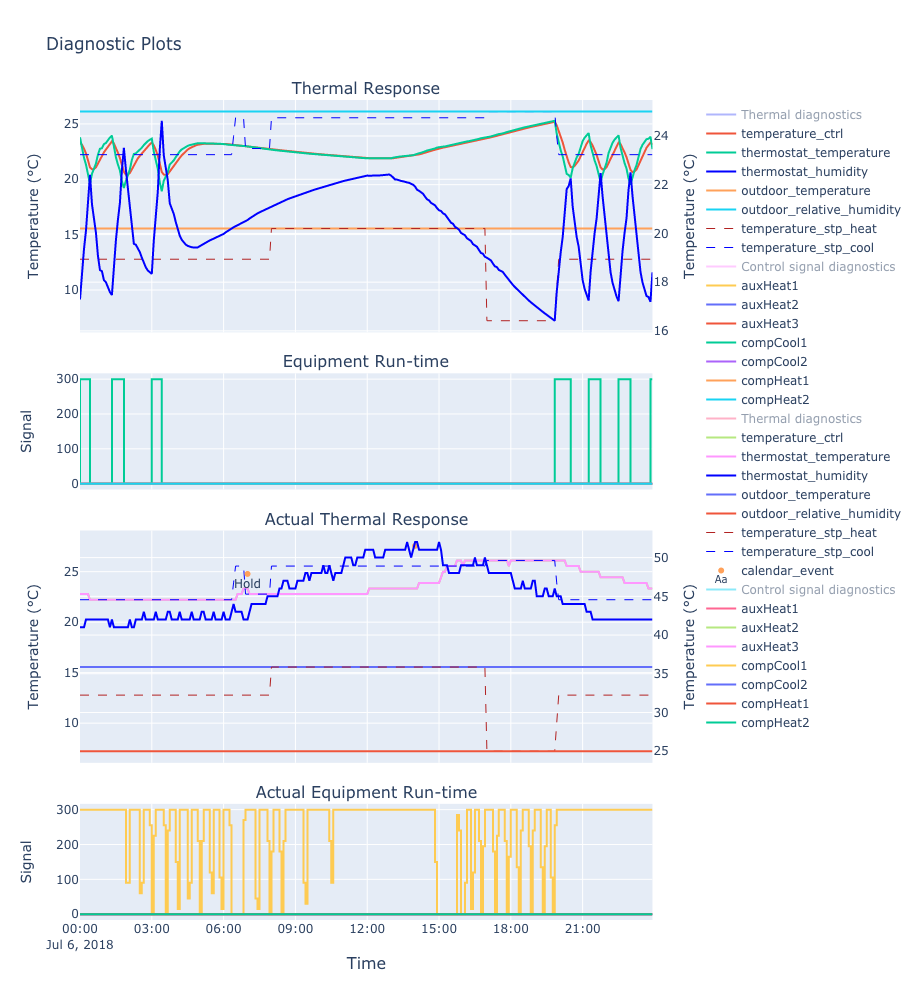

In [17]:
sim_analysis = OutputAnalysis(output_df=master.simulations[1].output, input_df=master.simulations[1].full_input, data_spec=dyd.internal_spec)
sim_analysis.diagnostic_plot(show=True, actuals=True)